![image](Logo_P6.JPG)

<h1 style = "text-align:center; color:green;border: solid green 3px;padding-top:15px;padding-bottom:15px;"> 2-Tests statistiques Projet 6 : les ventes d'une librairie avec R-Analyse  </h1>

In [3]:
rm(list=ls()) # On efface le cache (Pour ne pas saturer la mémoire vive Ram)

<a id="sec:librairies"></a>

---
#### *Les librairies utiles pour le projet*
---

In [4]:
library(readxl)
library(data.table)
library(reshape2)
library(datarium)
library(repr)
library(reshape2)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(ineq)
library(gridExtra)
library(MASS)
library(corrplot)

Warning message:
“package ‘readxl’ was built under R version 4.1.3”
Warning message:
“package ‘data.table’ was built under R version 4.1.3”
Warning message:
“package ‘reshape2’ was built under R version 4.1.3”

Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Warning message:
“package ‘repr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.2.1     ✔ purrr   1.0.1

In [5]:
categ <- c("0", "1", "2")
colors_for_categ <- c("#D83E81","#8BEAF0", "#FCE863")
names(colors_for_categ) <- categ
colors_for_categ

sex <- c("f", "m")
colors_for_sex <- c("deeppink", "deepskyblue2")
names(colors_for_sex) <- sex
colors_for_sex

0         1         2 
"#D83E81" "#8BEAF0" "#FCE863"

f              m 
    "deeppink" "deepskyblue2"

### <a id="sec:xlsx"></a>

#### *Importation notre base de données (Transactions_Produits_Clients.csv)*
---

In [6]:
Transactions_Produits_Clients <- fread("OUTPUT/Transactions_Produits_Clients.csv", encoding = "UTF-8")
Transactions_Produits_Clients <- Transactions_Produits_Clients %>% mutate(age = as.integer(format(Sys.Date(), "%Y")) - as.integer(birth)) # à corriger
Transactions_Produits_Clients <- Transactions_Produits_Clients[ , age := as.integer(age)]
Transactions_Produits_Clients <- Transactions_Produits_Clients[, categ := as.character(categ)]
Transactions_Produits_Clients_B2C <-Transactions_Produits_Clients[client_id != "c_1609" 
                                                                  & client_id !="c_4958" 
                                                                  & client_id !="c_6714" 
                                                                  & client_id !="c_3454",]
Transactions_Produits_Clients_B2C <- Transactions_Produits_Clients_B2C[ , age := as.integer(age)]
Transactions_Produits_Clients_B2C <- setDT(Transactions_Produits_Clients_B2C)
dim(Transactions_Produits_Clients_B2C)
head(Transactions_Produits_Clients_B2C,3)

[1] 632689     14

id_prod,price,categ,client_id,sex,birth,date,session_id,minute,heure,jour,mois,year,age
<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,<chr>,<chr>,<IDate>,<chr>,<int>,<int>
0_0,3.75,0,c_1004,m,1973,2021-03-02 21:57:33,s_908,2021-03-02 21:57,2021-03-02 21,2021-03-02,2021-03,2021,50
0_0,3.75,0,c_1011,f,1999,2022-03-18 16:40:10,s_180968,2022-03-18 16:40,2022-03-18 16,2022-03-18,2022-03,2022,24
0_0,3.75,0,c_1011,f,1999,2022-02-18 16:40:10,s_167174,2022-02-18 16:40,2022-02-18 16,2022-02-18,2022-02,2022,24


# TESTS STATISTIQUES
## 1. le lien entre le genre d’un client et les catégories des livres achetés

### Test sur categ_sex_age_B2C

In [7]:
# sex_categ
sex_categ <-         Transactions_Produits_Clients_B2C[,-c("heure",
                                                           "jour",
                                                           "mois",
                                                           "year",
                                                           "minute",
                                                           "birth",
                                                           "id_prod",
                                                           "client_id",
                                                           "session_id",
                                                           "date",
                                                            "age")]

sex_categ <- setDT(sex_categ)
dim(sex_categ)
head(sex_categ,3)

[1] 632689      3

price,categ,sex
<dbl>,<chr>,<chr>
3.75,0,m
3.75,0,f
3.75,0,f


In [8]:
# Vérifier le type de la variable 'sex'
cat("Type de la variable 'sex' :", class(sex_categ$sex), "\n")
# Vérifier le type de la variable 'categ'
cat("Type de la variable 'categ' :", class(sex_categ$categ), "\n")

Type de la variable 'sex' : character 
Type de la variable 'categ' : character 


In [9]:
# sex_categ

data <- sex_categ

# Déterminer le type de chaque variable
cat_vars <- c("sex","categ")
for (var in cat_vars) {
  cat_type <- ifelse(length(unique(data[[var]])) == 2, "nominal", "ordinal")
  cat_msg <- paste(var, "est une variable", cat_type, "avec", length(unique(data[[var]])), "catégories.")
  print(cat_msg)
}

[1] "sex est une variable nominal avec 2 catégories."
[1] "categ est une variable ordinal avec 3 catégories."


### 1. Créez un tableau de contingence: 
- Croise les catégories de deux variables qualitatives "sex" et "categ".
- Cette table est utile pour évaluer la relation entre le genre et les catégories de livres achetés

In [10]:
# 1. Créez un tableau de contingence: croise les catégories de deux variables qualitatives "sex" et "categ".
contingency_table <- table(sex_categ$sex, sex_categ$categ)
print(contingency_table)

   
         0      1      2
  f 200904 111331  16980
  m 186589 101017  15868


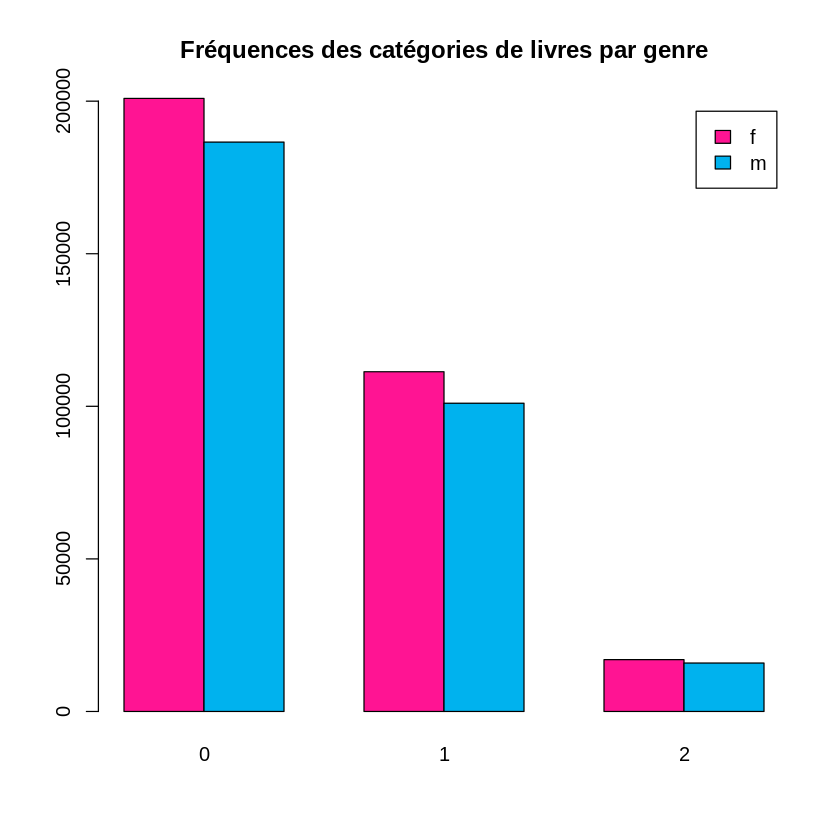

In [11]:
# # Diagramme en barres
barplot(contingency_table, beside = TRUE, legend.text = rownames(contingency_table),
        col = colors_for_sex, main = "Fréquences des catégories de livres par genre")

- **Nous pouvons voir qu'il y a plus de ventes chez les femmes que chez les hommes dans toutes les catégories, au premier abord, constater qu'il y a une différence de comportement entre les genres.**

### 2.Test du Khi-Deux

Ce test est préconisé pour évaluer la dépendance entre deux variables catégorielles comme c'est ici le cas.
Je commence par produire le tableau de contingence qui fournit les effectifs de vente selon le sexe et la catégorie
Je génère ensuite le test.
Dans ce test l’hypothèse nulle est simplement que les deux variables testées(à savoir le sexe et la catégorie des livres achetés) sont indépendantes

- H0, l'hypothèse nulle d'indépendance des variables
- H1, l'hypothèse alternative de dépendances des variables

Pour un risque de 5% :

Si la p-value obtenue est inférieure à 0.05 on peut alors rejeter l'hypothèse nulle.

In [12]:
# le lien entre le genre d’un client et les catégories des livres achetés 
chisq.test(sex_categ$categ,sex_categ$sex)


	Pearson's Chi-squared test

data:  sex_categ$categ and sex_categ$sex
X-squared = 20.2, df = 2, p-value = 4.108e-05


La statistique de test X-squared est de 20.2, le nombre de degrés de liberté est de 2 et la valeur p est de 4.108e-05 1. **Étant donné que la valeur p est inférieure à 0,05, on peut rejeter l’hypothèse nulle d’indépendance entre les deux variables et conclure qu’il existe une relation significative entre les variables sex et categ.**

## 2.Le lien entre l'âge des clients et le montant total des achats

### Tests sur panier_freq_CA_age_B2C

In [14]:
# #age_CA_B2C
CA_age_B2C <- Transactions_Produits_Clients_B2C %>%
  group_by(age) %>%
  summarise(CA_age = sum(price))
# dim(CA_age_B2C) #8600   5
# head(CA_age_B2C,3)

#Calcul du frequence_achat
freq_age_B2C <- Transactions_Produits_Clients_B2C %>%
  group_by(age) %>%
  summarise(freq_age = n_distinct(session_id))
# dim(freq_age_B2C) #8600    2
# head(freq_age_B2C,3);

# # Taile_panier_moyenne
panier_freq_CA_age_B2C <- merge(CA_age_B2C,freq_age_B2C,by="age",all = T)
panier_freq_CA_age_B2C <- panier_freq_CA_age_B2C %>% mutate(panier_age =CA_age/freq_age)
# panier_freq_CA_age_B2C <- panier_freq_CA_age_B2C[order(panier_freq_CA_age_B2C$CA_age, decreasing = TRUE),]
panier_freq_CA_age_B2C <- setDT(panier_freq_CA_age_B2C)
dim(panier_freq_CA_age_B2C) #8600     8
head(panier_freq_CA_age_B2C,3)

[1] 76  4

age,CA_age,freq_age,panier_age
<int>,<dbl>,<int>,<dbl>
19,609013.7,8594,70.86499
20,178195.8,2567,69.41791
21,184209.3,2604,70.74089


In [15]:
# Vérifier le type de la variable 'age' après la conversion
cat("Type de la variable 'age' :", class(panier_freq_CA_age_B2C$age), "\n")

# Vérifier le type de la variable 'CA_age' après la conversion
cat("Type de la variable 'CA_age' :", class(panier_freq_CA_age_B2C$CA_age), "\n")

Type de la variable 'age' : integer 
Type de la variable 'CA_age' : numeric 


In [16]:
# panier_freq_CA_age_B2C

data <- panier_freq_CA_age_B2C

# Déterminer le type de chaque variable
num_vars <- c("age","CA_age")
for (var in num_vars) {
  num_type <- ifelse(is.integer(data[[var]]) | is.numeric(data[[var]]), "continue", "discrete")
  num_msg <- paste(var, "est une variable", num_type, "avec une plage de valeurs allant de", min(data[[var]]), "à", max(data[[var]]), ".")
  print(num_msg)
}

[1] "age est une variable continue avec une plage de valeurs allant de 19 à 94 ."
[1] "CA_age est une variable continue avec une plage de valeurs allant de 2815.45 à 609013.69 ."


[1] "Âge moyen :  56.5"
[1] "Âge médian :  56.5"
[1] "Écart-type de l'âge :  22.0831761000692"
[1] "Montant moyen des achats :  144407.282445991"
[1] "Montant médian des achats :  143517.045"
[1] "Écart-type des achats :  112813.691974471"


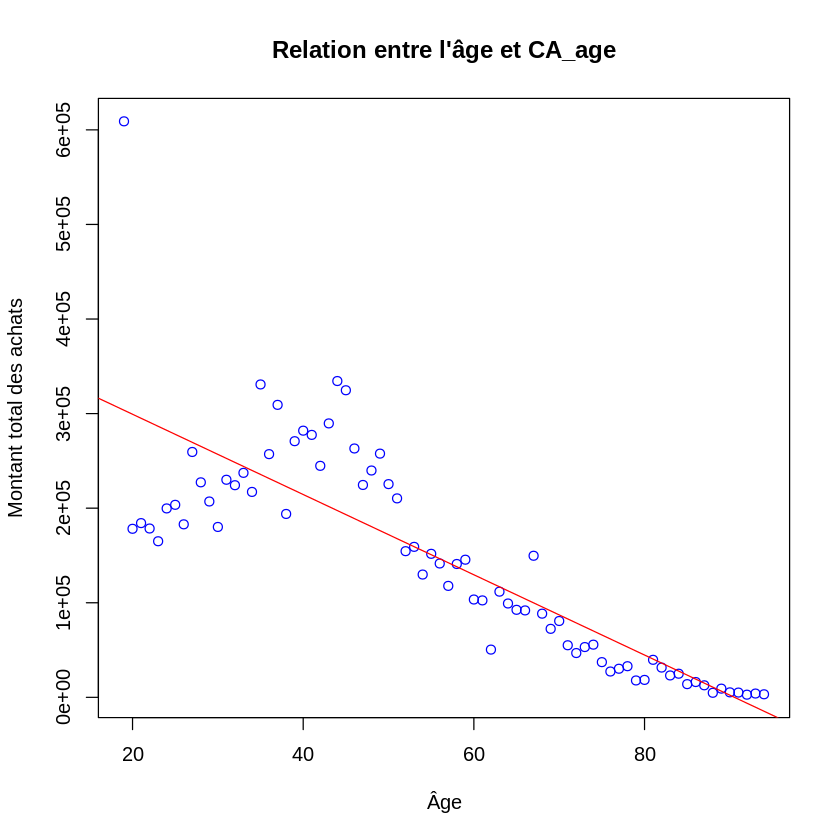

In [17]:
# Indicateurs de tendance centrale et de dispersion
mean_age <- mean(panier_freq_CA_age_B2C$age)
median_age <- median(panier_freq_CA_age_B2C$age)
sd_age <- sd(panier_freq_CA_age_B2C$age)

mean_CA <- mean(panier_freq_CA_age_B2C$CA_age)
median_CA <- median(panier_freq_CA_age_B2C$CA_age)
sd_CA <- sd(panier_freq_CA_age_B2C$CA_age)

print(paste("Âge moyen : ", mean_age))
print(paste("Âge médian : ", median_age))
print(paste("Écart-type de l'âge : ", sd_age))

print(paste("Montant moyen des achats : ", mean_CA))
print(paste("Montant médian des achats : ", median_CA))
print(paste("Écart-type des achats : ", sd_CA))

# Représentations graphiques :

plot(panier_freq_CA_age_B2C$age, panier_freq_CA_age_B2C$CA_age,
     xlab = "Âge", ylab = "Montant total des achats", main = "Relation entre l'âge et CA_age", col = "blue")

# Courbe de régression linéaire
lm_model <- lm(CA_age ~ age, data = panier_freq_CA_age_B2C)
abline(lm_model, col = "red")

### 1.Le test de Shapiro-Wilk
Le test de Shapiro-Wilk est utilisé pour vérifier si une variable suit une distribution normale. La statistique de test est W, et la valeur p est la probabilité que les données soient issues d’une distribution normale. Si la valeur p est inférieure à un seuil prédéfini (par exemple, 0,05), l’hypothèse nulle selon laquelle les données sont issues d’une distribution normale est rejetée.

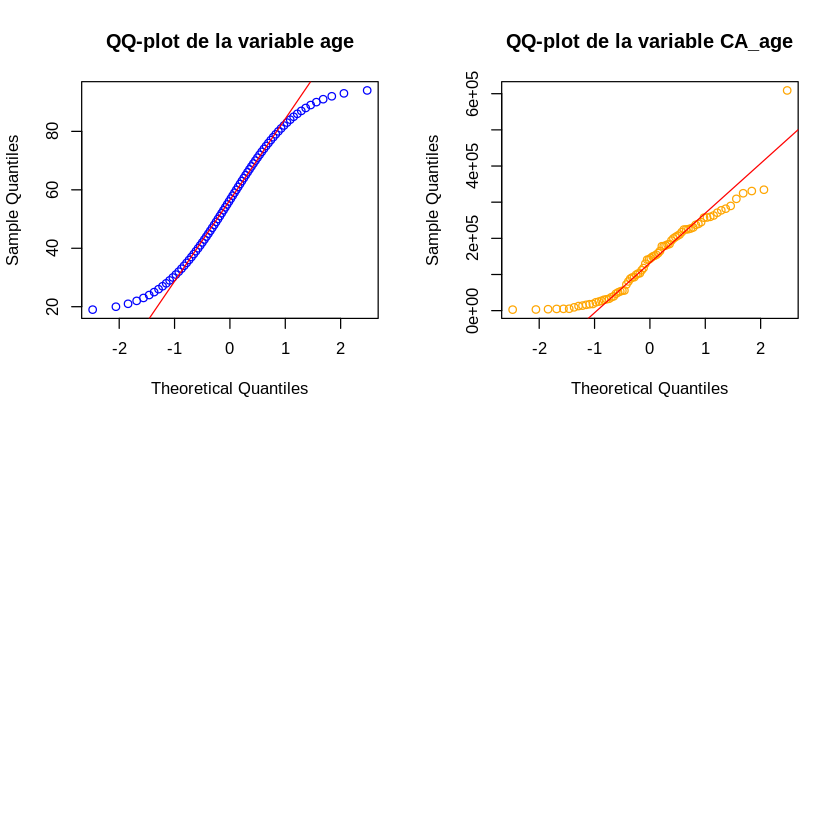

In [18]:
# Effectuer un test de normalité de Shapiro-Wilk pour chaque variable
shapiro_results <- apply(panier_freq_CA_age_B2C, 2, shapiro.test)

# Définir une palette de couleurs
my_colors <- c("blue", "orange", "green", "purple","red")

# Visualiser les résultats
par(mfrow = c(2, 2))
qqnorm(panier_freq_CA_age_B2C$age, main = "QQ-plot de la variable age", col = my_colors[1])
qqline(panier_freq_CA_age_B2C$age, col = my_colors[5])

qqnorm(panier_freq_CA_age_B2C$CA_age, main = "QQ-plot de la variable CA_age", col = my_colors[2])
qqline(panier_freq_CA_age_B2C$CA_age, col = my_colors[5])

In [19]:
shapiro.test(panier_freq_CA_age_B2C$age)
shapiro.test(panier_freq_CA_age_B2C$CA_age)


	Shapiro-Wilk normality test

data:  panier_freq_CA_age_B2C$age
W = 0.95492, p-value = 0.008753



	Shapiro-Wilk normality test

data:  panier_freq_CA_age_B2C$CA_age
W = 0.91173, p-value = 6.049e-05


Voici les résultats du test de normalité de Shapiro-Wilk pour chaque variable :

- Pour la variable “age”, la statistique de test est W = 0.95492 et la valeur p est 0.008753.
- Pour la variable “CA_age”, la statistique de test est W = 0.91173 et la valeur p est 6.049e-05.
- les résultats du test de Shapiro-Wilk montrent que les variables “age”, “CA_age” ne suivent pas une distribution normale, car les valeurs p sont inférieures à 0,05.
- **Cela signifie que  les corrélations de Spearman ou de Kendall doivent être utilisées pour mesurer la relation monotone entre “age”et “CA_age”.**

### 2.Corrélation de Spearman
Le coefficient de corrélation de Spearman mesure la relation monotone entre deux variables. Il varie de -1 à 1, où -1 indique une relation négative parfaite, 0 indique l’absence de relation et 1 indique une relation positive parfaite. Les termes “faible”, “modéré” et “fort” sont souvent utilisés pour décrire la force de la corrélation. Cependant, il n’y a pas de consensus sur les valeurs seuils pour définir ces termes. En général, une corrélation de 0,1 à 0,3 est considérée comme faible, une corrélation de 0,3 à 0,5 est considérée comme modérée et une corrélation supérieure à 0,5 est considérée comme forte.

In [20]:
# Calculer la matrice de corrélation de Spearman ("age", "CA_age")
cor_matrix_spearman <- cor(panier_freq_CA_age_B2C[, c("age", "CA_age")], method = "spearman")
cor_matrix_spearman

,age,CA_age
age,1.0000000,-0.8736842
CA_age,-0.8736842,1.0000000


Le coefficient de corrélation de Spearman entre age et CA_age est de -0.8736842. **Cela indique une forte relation négative monotone entre les deux variables. En d’autres termes, plus l’âge est élevé, plus la valeur de CA_age est faible et inversement.**

### 3.Corrélation de kendall
Le coefficient de corrélation de Kendall mesure la corrélation de rang entre deux variables. Il varie de -1 à 1, où -1 indique une relation négative parfaite, 0 indique l’absence de relation et 1 indique une relation positive parfaite.Les termes “faible”, “modéré” et “fort” sont souvent utilisés pour décrire la force de la corrélation. Cependant, il n’y a pas de consensus sur les valeurs seuils pour définir ces termes. En général, une corrélation de 0,1 à 0,3 est considérée comme faible, une corrélation de 0,3 à 0,5 est considérée comme modérée et une corrélation supérieure à 0,5 est considérée comme forte

In [21]:
# Calculer la matrice de corrélation de Kendall ("age", "CA_age")
cor_matrix_kendall <- cor(panier_freq_CA_age_B2C[, c("age", "CA_age")], method = "kendall")
cor_matrix_kendall

,age,CA_age
age,1.0000000,-0.7080702
CA_age,-0.7080702,1.0000000


Le coefficient de corrélation de Kendall entre age et CA_age est de -0.7080702. **Cela indique une forte relation négative monotone entre les deux variables. En d’autres termes, plus l’âge est élevé, plus la valeur de CA_age est faible et inversement.**

## 3.Le lien entre l'âge des clients et la fréquence d’achat

In [22]:
# Vérifier le type de la variable 'age' après la conversion
cat("Type de la variable 'age' :", class(panier_freq_CA_age_B2C$age), "\n")

# Vérifier le type de la variable 'Taile_panier_moyenne' après la conversion
cat("Type de la variable 'freq_age' :", class(panier_freq_CA_age_B2C$freq_age), "\n")

Type de la variable 'age' : integer 
Type de la variable 'freq_age' : integer 


In [23]:
# panier_freq_CA_age_B2C

data <- panier_freq_CA_age_B2C

# Déterminer le type de chaque variable
num_vars <- c("age","freq_age")
for (var in num_vars) {
  num_type <- ifelse(is.integer(data[[var]]) | is.numeric(data[[var]]), "continue", "discrete")
  num_msg <- paste(var, "est une variable", num_type, "avec une plage de valeurs allant de", min(data[[var]]), "à", max(data[[var]]), ".")
  print(num_msg)
}

[1] "age est une variable continue avec une plage de valeurs allant de 19 à 94 ."
[1] "freq_age est une variable continue avec une plage de valeurs allant de 96 à 10303 ."


[1] "Âge moyen :  56.5"
[1] "Âge médian :  56.5"
[1] "Écart-type de l'âge :  22.0831761000692"
[1] "Montant moyen des freq_age :  4200.97368421053"
[1] "Montant médian des freq_age :  3475.5"
[1] "Écart-type des freq_age :  3028.74388913373"


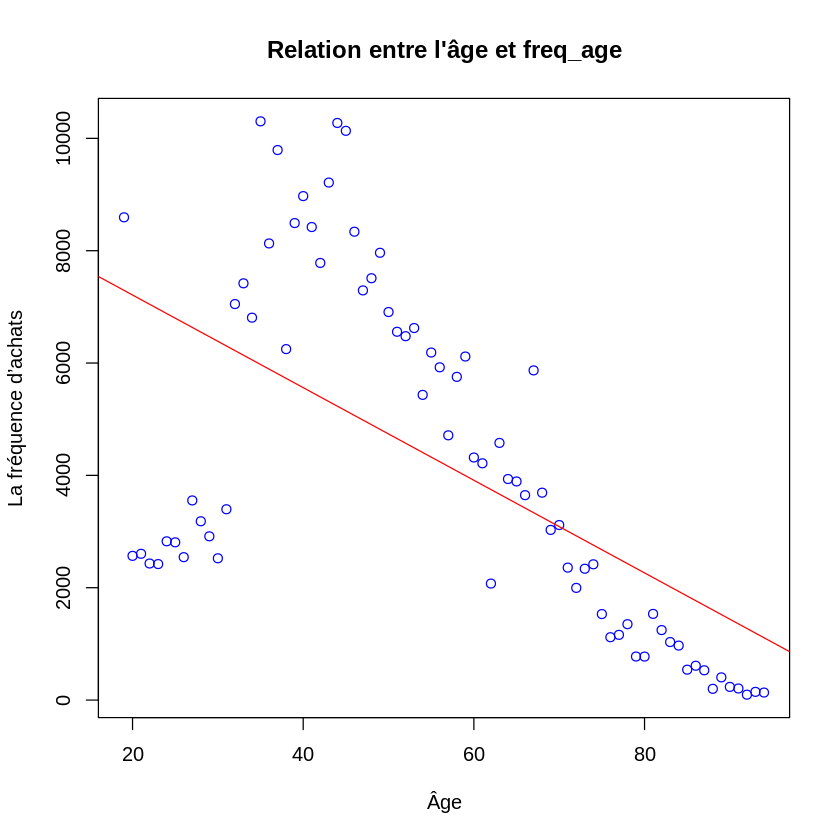

In [24]:
# Indicateurs de tendance centrale et de dispersion
mean_age <- mean(panier_freq_CA_age_B2C$age)
median_age <- median(panier_freq_CA_age_B2C$age)
sd_age <- sd(panier_freq_CA_age_B2C$age)

mean_freq <- mean(panier_freq_CA_age_B2C$freq_age)
median_freq <- median(panier_freq_CA_age_B2C$freq_age)
sd_freq <- sd(panier_freq_CA_age_B2C$freq_age)

print(paste("Âge moyen : ", mean_age))
print(paste("Âge médian : ", median_age))
print(paste("Écart-type de l'âge : ", sd_age))

print(paste("Montant moyen des freq_age : ", mean_freq))
print(paste("Montant médian des freq_age : ", median_freq))
print(paste("Écart-type des freq_age : ", sd_freq))

# Représentations graphiques:

plot(panier_freq_CA_age_B2C$age, panier_freq_CA_age_B2C$freq_age,
     xlab = "Âge", ylab = "La fréquence d’achats", main = "Relation entre l'âge et freq_age", col = "blue")

# Courbe de régression linéaire
lm_model <- lm(freq_age ~ age, data = panier_freq_CA_age_B2C)
abline(lm_model, col = "red")

### 1.Le test de Shapiro-Wilk

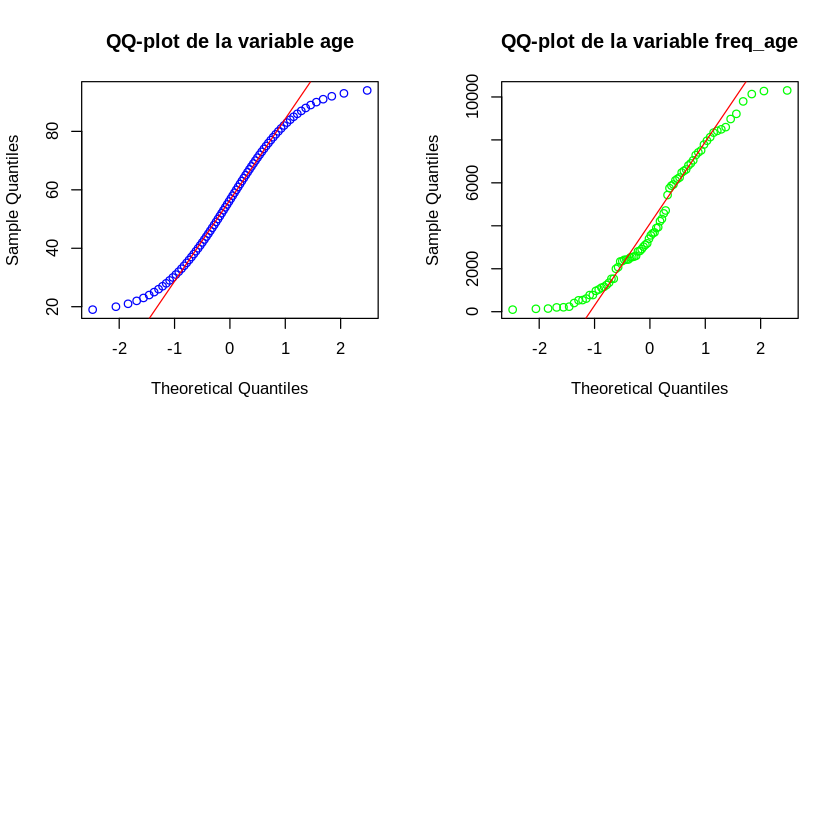

In [25]:
# Effectuer un test de normalité de Shapiro-Wilk pour chaque variable
shapiro_results <- apply(panier_freq_CA_age_B2C, 2, shapiro.test)

# Définir une palette de couleurs
my_colors <- c("blue", "orange", "green", "purple","red")

# Visualiser les résultats
par(mfrow = c(2, 2))
qqnorm(panier_freq_CA_age_B2C$age, main = "QQ-plot de la variable age", col = my_colors[1])
qqline(panier_freq_CA_age_B2C$age, col = my_colors[5])

qqnorm(panier_freq_CA_age_B2C$freq_age, main = "QQ-plot de la variable freq_age", col = my_colors[3])
qqline(panier_freq_CA_age_B2C$freq_age, col = my_colors[5])

In [26]:
shapiro.test(panier_freq_CA_age_B2C$age)
shapiro.test(panier_freq_CA_age_B2C$freq_age)


	Shapiro-Wilk normality test

data:  panier_freq_CA_age_B2C$age
W = 0.95492, p-value = 0.008753



	Shapiro-Wilk normality test

data:  panier_freq_CA_age_B2C$freq_age
W = 0.93242, p-value = 0.0005561


Voici les résultats du test de normalité de Shapiro-Wilk pour chaque variable :
- Pour la variable “age”, la statistique de test est W = 0.95492 et la valeur p est 0.008753.
- Pour la variable “freq_age”, la statistique de test est W = 0.93242 et la valeur p est 0.0005561.
- les résultats du test de Shapiro-Wilk montrent que les variables “age” et “freq_age” ne suivent pas une distribution normale, car les valeurs p sont inférieures à 0,05.
- **Cela signifie que les corrélations de Spearman ou de Kendall doivent être utilisées pour mesurer la relation monotone entre “age”et “freq_age”.**

### 2.Corrélation de Spearman

In [27]:
# Calculer la matrice de corrélation de Spearman ("age", "freq_age")
cor_matrix_spearman <- cor(panier_freq_CA_age_B2C[, c("age", "freq_age")], method = "spearman")
cor_matrix_spearman

,age,freq_age
age,1.0000000,-0.6593848
freq_age,-0.6593848,1.0000000


Le coefficient de corrélation de Spearman entre age et freq_age est de -0.6593848. **Cela indique une forte relation négative monotone entre les deux variables. En d’autres termes, plus l’âge est élevé, moins la valeur de freq_age est élevée et inversement.**

### 3. Corrélation de kendall

In [28]:
# Calculer la matrice de corrélation de Kendall ("age", "freq_age")
cor_matrix_kendall <- cor(panier_freq_CA_age_B2C[, c("age", "freq_age")], method = "kendall")
cor_matrix_kendall

,age,freq_age
age,1.0000000,-0.5445614
freq_age,-0.5445614,1.0000000


Le coefficient de corrélation de Kendall entre age et freq_age est de -0.5445614. **Cela indique une forte relation négative monotone entre les deux variables. En d’autres termes, plus l’âge est élevé, moins la valeur de freq_age est élevée et inversement.**

## 4.Le lien entre l'âge des clients et la taille du panier moyen

In [29]:
# Vérifier le type de la variable 'age' après la conversion
cat("Type de la variable 'age' :", class(panier_freq_CA_age_B2C$age), "\n")

# Vérifier le type de la variable 'panier_age' après la conversion
cat("Type de la variable 'panier_age' :", class(panier_freq_CA_age_B2C$panier_age), "\n")

Type de la variable 'age' : integer 
Type de la variable 'panier_age' : numeric 


In [30]:
# panier_freq_CA_age_B2C

data <- panier_freq_CA_age_B2C

# Déterminer le type de chaque variable
num_vars <- c("age","panier_age")
for (var in num_vars) {
  num_type <- ifelse(is.integer(data[[var]]) | is.numeric(data[[var]]), "continue", "discrete")
  num_msg <- paste(var, "est une variable", num_type, "avec une plage de valeurs allant de", min(data[[var]]), "à", max(data[[var]]), ".")
  print(num_msg)
}

[1] "age est une variable continue avec une plage de valeurs allant de 19 à 94 ."
[1] "panier_age est une variable continue avec une plage de valeurs allant de 22.397681499598 à 73.4256273138626 ."


[1] "Âge moyen :  56.5"
[1] "Âge médian :  56.5"
[1] "Écart-type de l'âge :  22.0831761000692"
[1] "Montant moyen de panier :  34.3681389506501"
[1] "Montant médian de panier :  25.8829430449394"
[1] "Écart-type de panier :  17.0618470582269"


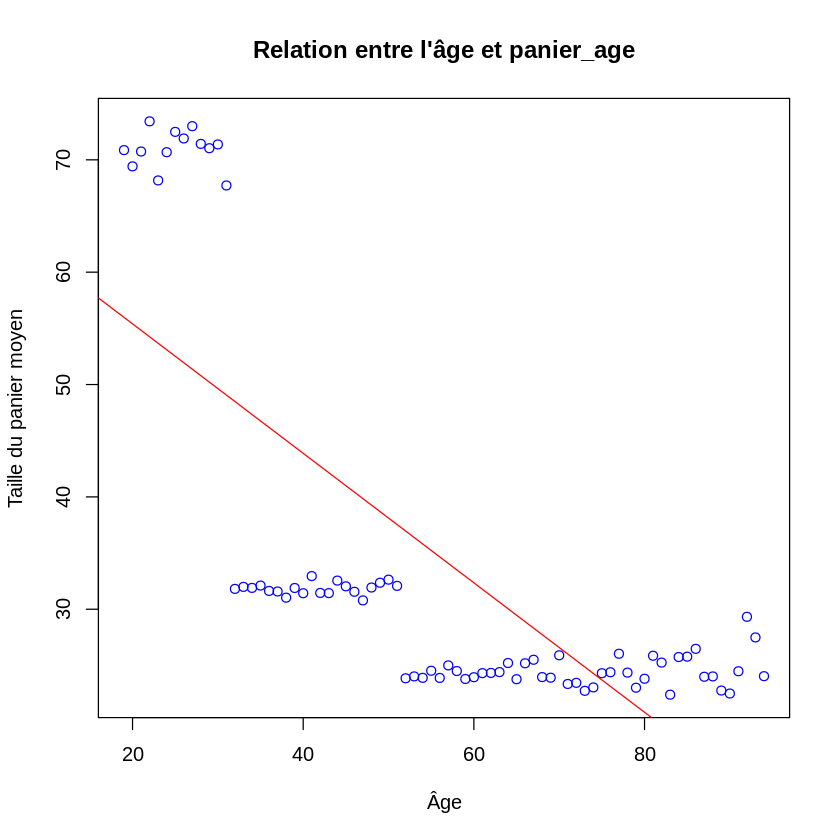

In [31]:

# Indicateurs de tendance centrale et de dispersion
mean_age <- mean(panier_freq_CA_age_B2C$age)
median_age <- median(panier_freq_CA_age_B2C$age)
sd_age <- sd(panier_freq_CA_age_B2C$age)

mean_panier <- mean(panier_freq_CA_age_B2C$panier_age)
median_panier <- median(panier_freq_CA_age_B2C$panier_age)
sd_panier <- sd(panier_freq_CA_age_B2C$panier_age)

print(paste("Âge moyen : ", mean_age))
print(paste("Âge médian : ", median_age))
print(paste("Écart-type de l'âge : ", sd_age))

print(paste("Montant moyen de panier : ", mean_panier))
print(paste("Montant médian de panier : ", median_panier))
print(paste("Écart-type de panier : ", sd_panier))

# Représentations graphiques:

plot(panier_freq_CA_age_B2C$age, panier_freq_CA_age_B2C$panier_age,
     xlab = "Âge", ylab = "Taille du panier moyen", main = "Relation entre l'âge et panier_age", col = "blue")

# Courbe de régression linéaire
lm_model <- lm(panier_age ~ age, data = panier_freq_CA_age_B2C)
abline(lm_model, col = "red")

### 1. Le test de Shapiro-Wilk

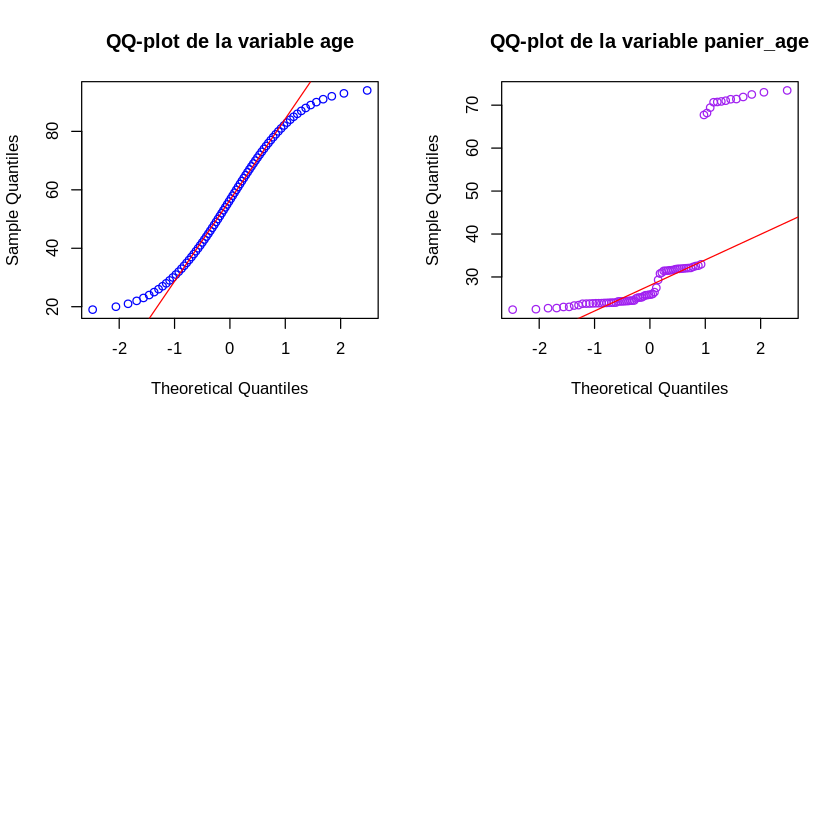

In [32]:
# Effectuer un test de normalité de Shapiro-Wilk pour chaque variable
shapiro_results <- apply(panier_freq_CA_age_B2C, 2, shapiro.test)

# Définir une palette de couleurs
my_colors <- c("blue", "orange", "green", "purple","red")

# Visualiser les résultats
par(mfrow = c(2, 2))
qqnorm(panier_freq_CA_age_B2C$age, main = "QQ-plot de la variable age", col = my_colors[1])
qqline(panier_freq_CA_age_B2C$age, col = my_colors[5])

qqnorm(panier_freq_CA_age_B2C$panier_age, main = "QQ-plot de la variable panier_age", col = my_colors[4])
qqline(panier_freq_CA_age_B2C$panier_age, col = my_colors[5])

In [33]:
shapiro.test(panier_freq_CA_age_B2C$age)
shapiro.test(panier_freq_CA_age_B2C$panier_age)


	Shapiro-Wilk normality test

data:  panier_freq_CA_age_B2C$age
W = 0.95492, p-value = 0.008753



	Shapiro-Wilk normality test

data:  panier_freq_CA_age_B2C$panier_age
W = 0.62249, p-value = 1.117e-12


Voici les résultats du test de normalité de Shapiro-Wilk pour chaque variable :
- Pour la variable “age”, la statistique de test est W = 0.95492 et la valeur p est 0.008753.
- Pour la variable “panier_age”, la statistique de test est W = 0.62249 et la valeur p est 1.117e-12.
- les résultats du test de Shapiro-Wilk montrent que les variables “age” et “panier_age” ne suivent pas une distribution normale, car les valeurs p sont inférieures à 0,05.
- **Cela signifie que  les corrélations de Spearman ou de Kendall doivent être utilisées pour mesurer la relation monotone entre “age”et “panier_age”.**

### 2. Corrélation de Spearman

In [34]:
# Calculer la matrice de corrélation de Spearman ("age", "panier_age")
cor_matrix_spearman <- cor(panier_freq_CA_age_B2C[, c("age", "panier_age")], method = "spearman")
cor_matrix_spearman

,age,panier_age
age,1.0000000,-0.7670267
panier_age,-0.7670267,1.0000000


Le coefficient de corrélation de Spearman entre age et panier_age est de -0.7670267. **Cela indique une forte relation négative monotone entre les deux variables. En d’autres termes, plus l’âge est élevé, moins la valeur de panier_age est élevée et inversement.**

### 3. Corrélation de kendall

In [35]:
# Calculer la matrice de corrélation de Kendall ("age", "panier_age")
cor_matrix_kendall <- cor(panier_freq_CA_age_B2C[, c("age", "panier_age")], method = "kendall")
cor_matrix_kendall

,age,panier_age
age,1.0000000,-0.5515789
panier_age,-0.5515789,1.0000000


Le coefficient de corrélation de Kendall entre age et panier_age est de -0.5515789. **Cela indique une forte relation négative monotone entre les deux variables. En d’autres termes, plus l’âge est élevé, moins la valeur de panier_age est élevée et inversement**

### Matrix de Spearman & kendall pour panier_freq_CA_age_B2C

,age,CA_age,freq_age,panier_age
age,1.0000000,-0.8736842,-0.6593848,-0.7670267
CA_age,-0.8736842,1.0000000,0.8987286,0.6895147
freq_age,-0.6593848,0.8987286,1.0000000,0.3917430
panier_age,-0.7670267,0.6895147,0.3917430,1.0000000


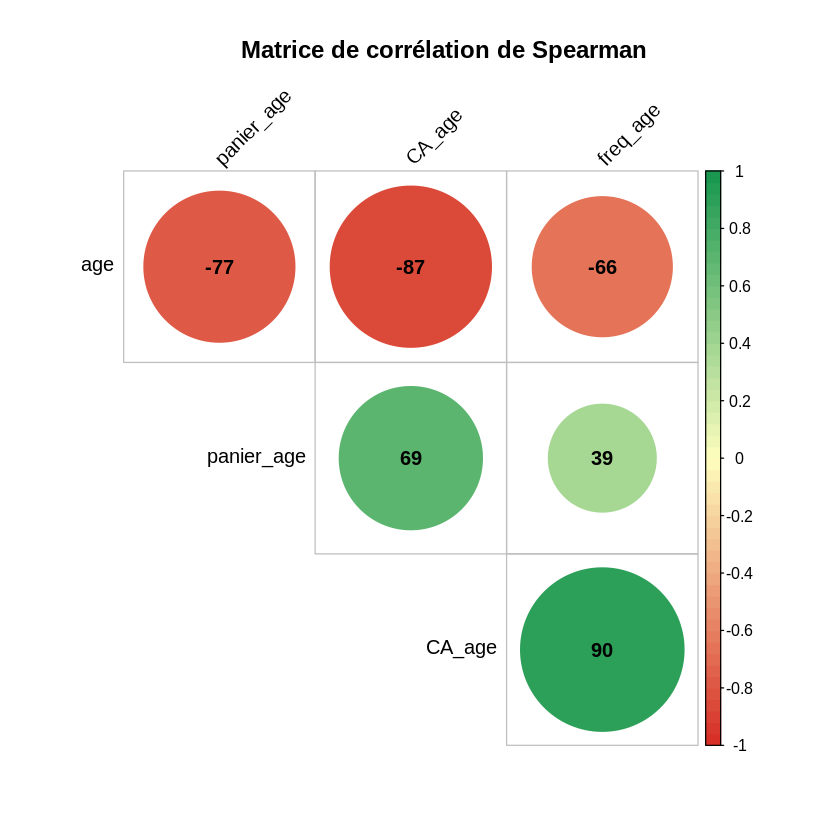

In [36]:
# Calculer la matrice de corrélation de Spearman
cor_matrix_spearman <- cor(panier_freq_CA_age_B2C, method = "spearman")
cor_matrix_spearman
# Visualiser les matrices de corrélation de Spearman
library(corrplot)
corrplot(cor_matrix_spearman, method = "circle", type = "upper", tl.col = "black", tl.srt = 45, diag = FALSE, addCoef.col = "black", addCoefasPercent = TRUE, order = "hclust", col = colorRampPalette(c("#D73027", "#FFFFBF", "#1A9850"))(50))
title("Matrice de corrélation de Spearman")

,age,CA_age,freq_age,panier_age
age,1.0000000,-0.7080702,-0.5445614,-0.5515789
CA_age,-0.7080702,1.0000000,0.8182456,0.4294737
freq_age,-0.5445614,0.8182456,1.0000000,0.2477193
panier_age,-0.5515789,0.4294737,0.2477193,1.0000000


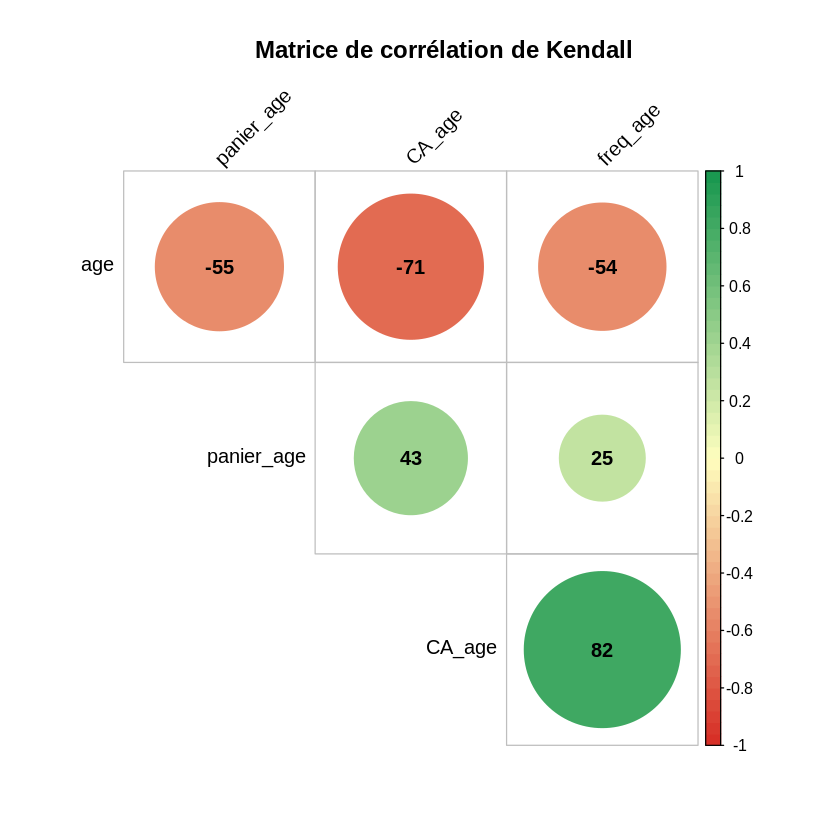

In [37]:
# Calculer la matrice de corrélation de Kendall
cor_matrix_kendall <- cor(panier_freq_CA_age_B2C, method = "kendall")
cor_matrix_kendall
# Visualiser les matrices de corrélation de Kendall
library(corrplot)
corrplot(cor_matrix_kendall, method = "circle", type = "upper", tl.col = "black", tl.srt = 45, diag = FALSE, addCoef.col = "black", addCoefasPercent = TRUE, order = "hclust", col = colorRampPalette(c("#D73027", "#FFFFBF", "#1A9850"))(50))
title("Matrice de corrélation de Kendall")

## 5. Le lien entre l'age d’un client et les catégories des livres achetés:
### A. TEST sur age_categ

- On cherche à demontrer mathématiquement une relation entre age et la catégorie
- on teste d'abord la distribution gaussienne via le test Shapiro
- Si il fonctionne on applique le test Anova, dans le cas contraire on applique le Kuskral Wallis plus adapté dans le cas de distributions non gaussiennes

Analyse graphique : la forme des distributions, les moyennes

Création d'un dataset âge des clients et catégorie des livres achetés

Test de Shapiro-Wilk et Leneve pour déterminer si les données sont normalement distribuées et si les variances des différents groupes sont homogènes.

Les hypothèses pour le test de Shapiro-Wilk sont les suivantes :

H0 (hypothèse nulle) : les données suivent une distribution normale
H1 (hypothèse alternative) : les données ne suivent pas une distribution normale
Les hypothèses pour le test de Levene sont les suivantes :

H0 : les variances des échantillons sont égales

H1 : au moins une des variances des échantillons est différente des autres

Test de Kruskal-Wallis pour déterminer s'il y a une différence significative entre les distributions des 3 groupes.

Les hypothèses pour le test de Kruskal-Wallis sont les suivantes :

H0 : les échantillons proviennent d'une population ayant la même distribution

H1 : au moins un échantillon provient d'une population ayant une distribution différente des autres

Vérification graphique d'une éventuelle corrélation entre la variable âge et la fréquence des achats.

In [38]:
# age_categ
age_categ <- Transactions_Produits_Clients_B2C %>% 
      group_by(age,categ) %>% 
      dplyr::summarise(nb_session = n())
    #print(dim(session_j))
#head(session_j)
age_categ <- setDT(age_categ)

age_categ_0<-age_categ[age_categ$categ == '0',]
age_categ_0 <- age_categ_0[,-c("categ")]
colnames(age_categ_0) <- c("age", "categ_0")
age_categ_1<-age_categ[age_categ$categ == '1',]
age_categ_1 <- age_categ_1[,-c("categ")]
colnames(age_categ_1) <- c("age", "categ_1")
age_categ_2<-age_categ[age_categ$categ == '2',]
age_categ_2 <- age_categ_2[,-c("categ")]
colnames(age_categ_2) <- c("age", "categ_2")

age_categ_3 <- merge(age_categ_0,age_categ_1, by="age",all = T)
age_categ <- merge(age_categ_3,age_categ_2, by="age",all = T)
age_categ <- setDT(age_categ)
dim(age_categ) #679553  X  8
head(age_categ,3)

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


[1] 76  4

age,categ_0,categ_1,categ_2
<int>,<int>,<int>,<int>
19,3418,5719,6012
20,909,1678,1784
21,1019,1723,1845


### 1. Le test de Shapiro-Wilk

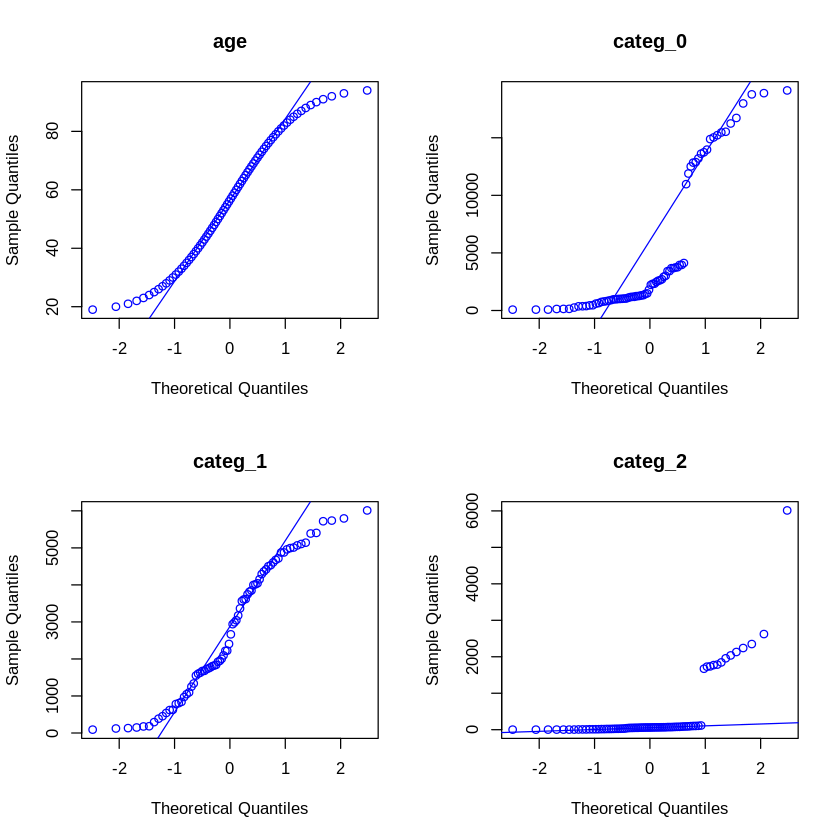

In [41]:
# Effectuer un test de normalité de Shapiro-Wilk pour chaque variable
shapiro_results <- apply(age_categ, 2, shapiro.test)

# Définir une palette de couleurs
my_colors <- c("blue")

# Visualiser les résultats
par(mfrow = c(2, 2))
for (col in names(age_categ)) {
 
  qqnorm(age_categ[[col]], main = col, col = my_colors)
  qqline(age_categ[[col]], col = my_colors)
}

In [42]:
shapiro.test(age_categ$age)
shapiro.test(age_categ$categ_0)
shapiro.test(age_categ$categ_1)
shapiro.test(age_categ$categ_2)


	Shapiro-Wilk normality test

data:  age_categ$age
W = 0.95492, p-value = 0.008753



	Shapiro-Wilk normality test

data:  age_categ$categ_0
W = 0.73473, p-value = 2.076e-10



	Shapiro-Wilk normality test

data:  age_categ$categ_1
W = 0.93534, p-value = 0.0007775



	Shapiro-Wilk normality test

data:  age_categ$categ_2
W = 0.47843, p-value = 5.581e-15


Les résultats du test de normalité de Shapiro-Wilk pour les variables `age`, `categ_0`, `categ_1` et `categ_2` sont présentés ci-dessous:

- Pour la variable `age`, la valeur de W est de 0,95492 et la valeur p est de 0,008753. Étant donné que la valeur p est inférieure à 0,05, on peut rejeter l'hypothèse nulle selon laquelle les données suivent une distribution normale.
- Pour la variable `categ_0`, la valeur de W est de 0,73473 et la valeur p est de 2,076e-10. Étant donné que la valeur p est inférieure à 0,05, on peut rejeter l'hypothèse nulle selon laquelle les données suivent une distribution normale.
- Pour la variable `categ_1`, la valeur de W est de 0,93534 et la valeur p est de 0,0007775. Étant donné que la valeur p est inférieure à 0,05, on peut rejeter l'hypothèse nulle selon laquelle les données suivent une distribution normale.
- Pour la variable `categ_2`, la valeur de W est de 0,47843 et la valeur p est de 5,581e-15. Étant donné que la valeur p est inférieure à 0,05, on peut rejeter l'hypothèse nulle selon laquelle les données suivent une distribution normale.

En résumé, les résultats du test de normalité de Shapiro-Wilk suggèrent que les données pour les variables `age`, `categ_0`, `categ_1` et `categ_2` ne suivent pas une distribution normale. Cela signifie que les analyses statistiques qui supposent une distribution normale des données peuvent ne pas être appropriées pour ces variables.

Les variables age, categ_0, categ_1 et categ_2 sont des variables quantitatives. Cependant, comme ces variables ne suivent pas une distribution normale, il est recommandé d’utiliser des tests statistiques non paramétriques pour évaluer les relations entre ces variables.

**Un test statistique non paramétrique couramment utilisé pour évaluer la relation entre deux variables quantitatives est soit le test de corrélation de Spearman ou Kendall.**

### 2. Corrélation de Spearman

,age,categ_0,categ_1,categ_2
age,1.0000000,-0.5619664,-0.5759945,-0.9056614
categ_0,-0.5619664,1.0000000,0.9541549,0.5112670
categ_1,-0.5759945,0.9541549,1.0000000,0.6002420
categ_2,-0.9056614,0.5112670,0.6002420,1.0000000


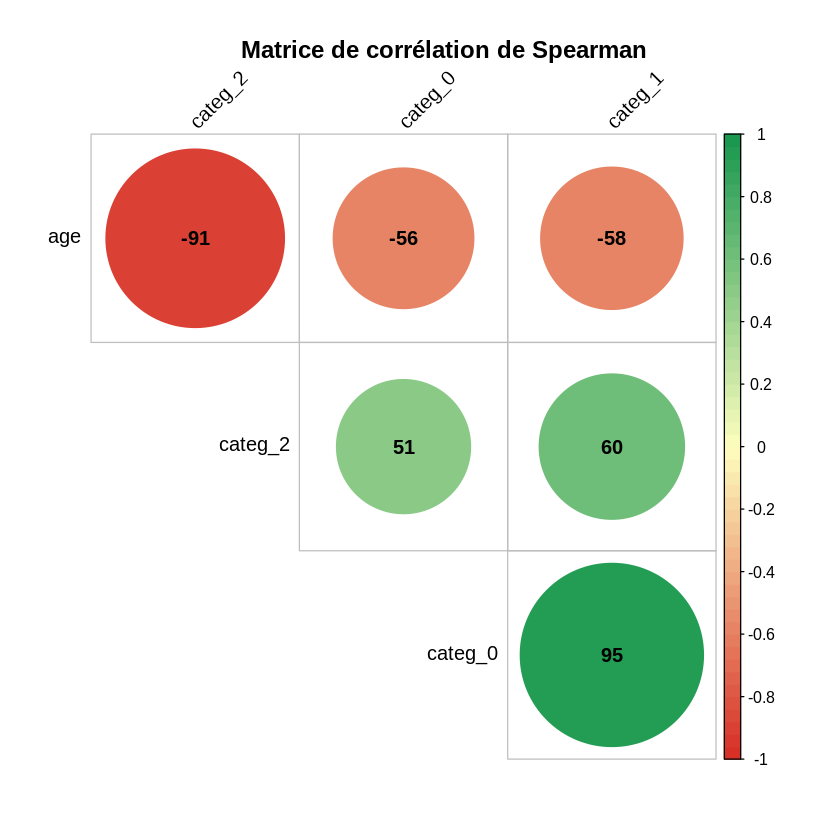

In [43]:
library(corrplot)
# Calculer la matrice de corrélation de Spearman
cor_matrix_spearman <- cor(age_categ, method = "spearman")
cor_matrix_spearman

# Visualiser les matrices de corrélation de Spearman
corrplot(cor_matrix_spearman, method = "circle", type = "upper", tl.col = "black", tl.srt = 45, diag = FALSE, addCoef.col = "black", addCoefasPercent = TRUE, order = "hclust", col = colorRampPalette(c("#D73027", "#FFFFBF", "#1A9850"))(50))
title("Matrice de corrélation de Spearman")

Les résultats montrent que la variable age est négativement corrélée avec les variables categ_0, categ_1 et categ_2. Cela signifie que plus l’âge est élevé, moins il y a de sessions pour les catégories 0, 1 et 2. La corrélation entre age et categ_2 est particulièrement forte, avec une valeur de corrélation de -0,905661.

### 3. Corrélation de kendall

,age,categ_0,categ_1,categ_2
age,1.0000000,-0.4791996,-0.4414035,-0.7324351
categ_0,-0.4791996,1.0000000,0.8548360,0.4032454
categ_1,-0.4414035,0.8548360,1.0000000,0.4879378
categ_2,-0.7324351,0.4032454,0.4879378,1.0000000


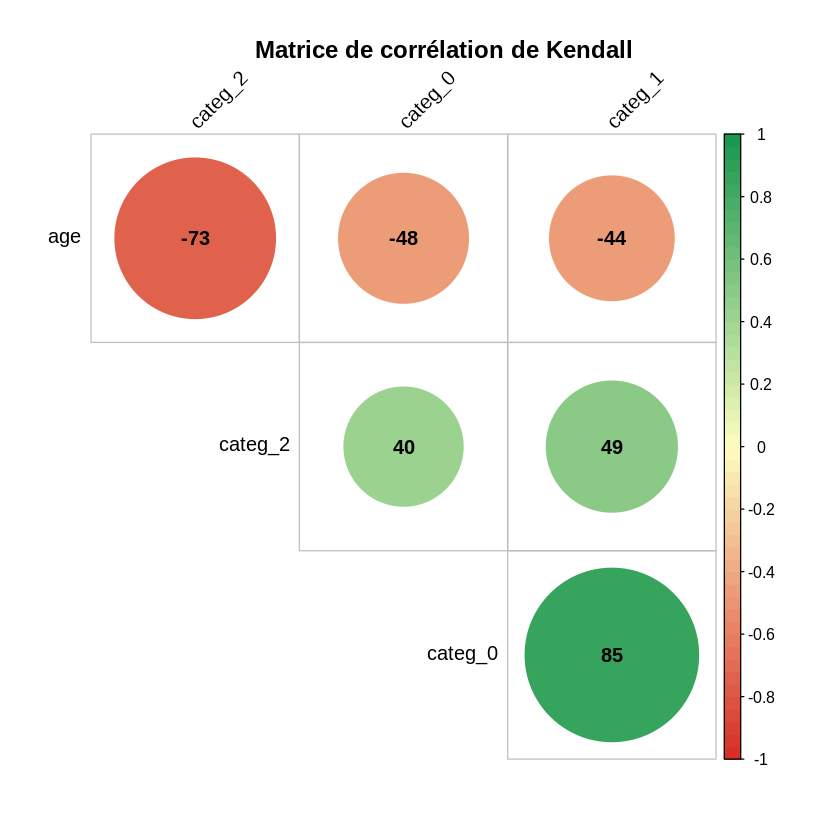

In [44]:
library(corrplot)
# Calculer la matrice de corrélation de Kendall
cor_matrix_kendall <- cor(age_categ, method = "kendall")
cor_matrix_kendall

# Visualiser les matrices de corrélation de Kendall
corrplot(cor_matrix_kendall, method = "circle", type = "upper", tl.col = "black", tl.srt = 45, diag = FALSE, addCoef.col = "black", addCoefasPercent = TRUE, order = "hclust", col = colorRampPalette(c("#D73027", "#FFFFBF", "#1A9850"))(50))
title("Matrice de corrélation de Kendall")

Les résultats montrent que la variable age est négativement corrélée avec les variables categ_0, categ_1 et categ_2. Cela signifie que plus l’âge est élevé, moins il y a de sessions pour les catégories 0, 1 et 2. La corrélation entre age et categ_2 est particulièrement forte, avec une valeur de corrélation de -0,7324351.

## 5. Le lien entre l'age d’un client et les catégories des livres achetés:
### B. TEST sur Transactions_Produits_Clients_B2C

In [48]:
# Vérifier le type de la variable 'age'
cat("Type de la variable 'age' :", class(Transactions_Produits_Clients_B2C$age), "\n")
# Vérifier le type de la variable 'categ'
Transactions_Produits_Clients_B2C$categ <- as.numeric(Transactions_Produits_Clients_B2C$categ)
cat("Type de la variable 'categ' :", class(Transactions_Produits_Clients_B2C$categ), "\n")

Type de la variable 'age' : integer 
Type de la variable 'categ' : numeric 


In [49]:
# categ_sex_age_B2C
data <- Transactions_Produits_Clients_B2C

# Déterminer le type de chaque variable
num_vars <- c("age","categ")
for (var in num_vars) {
  num_type <- ifelse(is.integer(data[[var]]) | is.numeric(data[[var]]), "continue", "discrete")
  num_msg <- paste(var, "est une variable", num_type, "avec une plage de valeurs allant de", min(data[[var]]), "à", max(data[[var]]), ".")
  print(num_msg)
}

[1] "age est une variable continue avec une plage de valeurs allant de 19 à 94 ."
[1] "categ est une variable continue avec une plage de valeurs allant de 0 à 2 ."


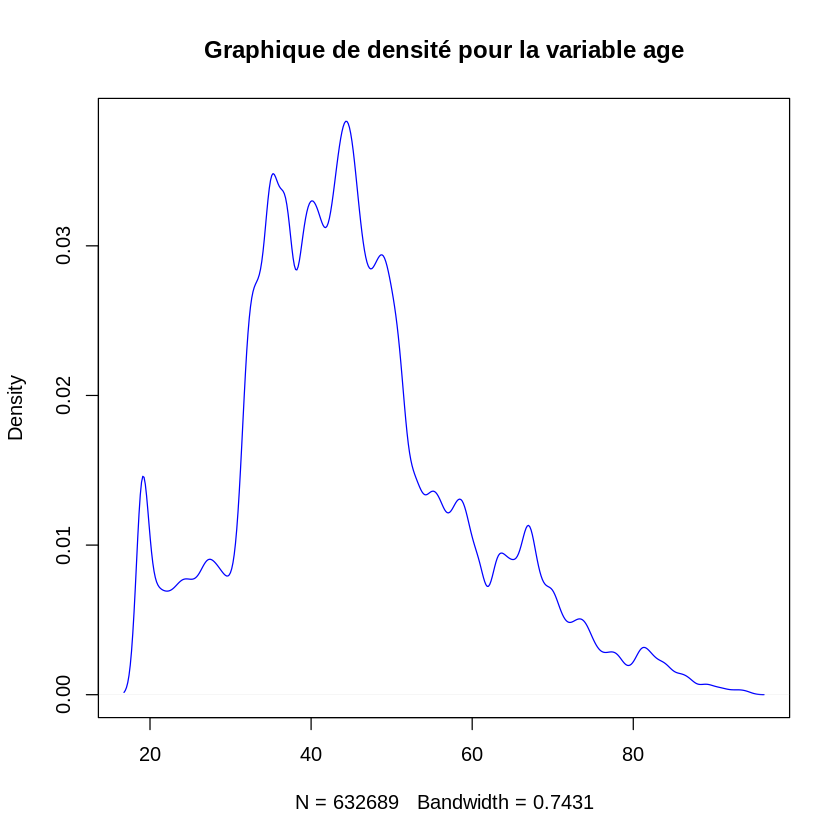

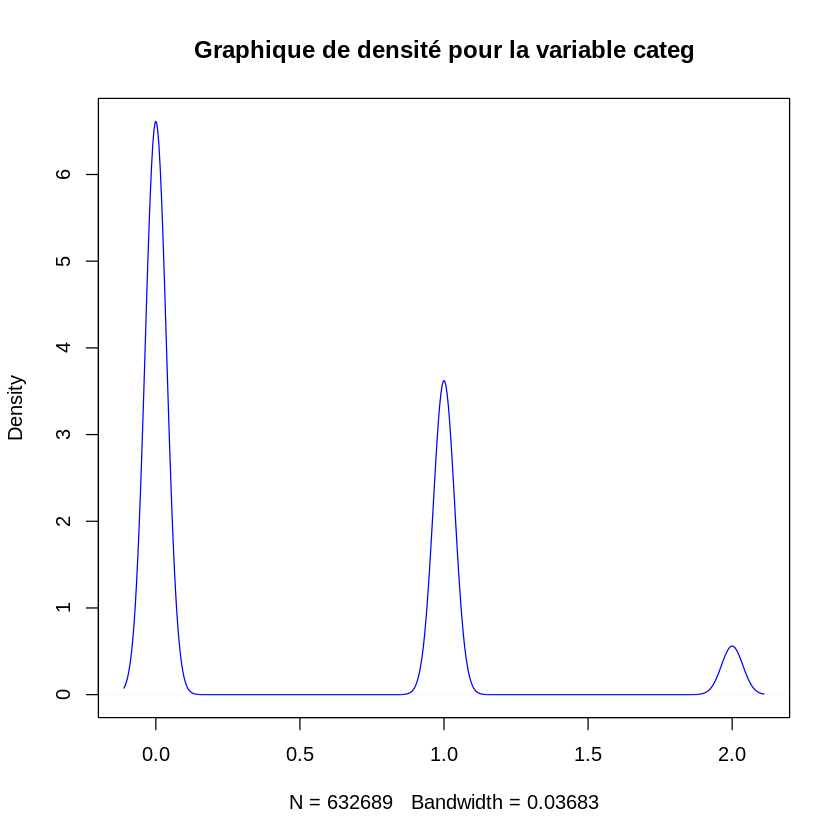

In [50]:
# Créer un graphique de densité pour la variable age
plot(density(Transactions_Produits_Clients_B2C$age), main = "Graphique de densité pour la variable age",col = "blue")
Transactions_Produits_Clients_B2C$categ <- as.numeric(Transactions_Produits_Clients_B2C$categ)
plot(density(Transactions_Produits_Clients_B2C$categ), main = "Graphique de densité pour la variable categ",col = "blue")

### 1. Le test de Shapiro-Wilk

In [51]:
shapiro.test(Transactions_Produits_Clients_B2C$age)
shapiro.test(Transactions_Produits_Clients_B2C$categ)

ERROR: Error in shapiro.test(Transactions_Produits_Clients_B2C$age): sample size must be between 3 and 5000


In [52]:
length(Transactions_Produits_Clients_B2C$age)

[1] 632689

La fonction `shapiro.test()` ne peut être utilisée que pour des échantillons de taille comprise entre 3 et 5000. Cependant, il existe d'autres tests statistiques pour évaluer la normalité de la distribution de nos données. Un test statistique couramment utilisé pour les échantillons de grande taille est le test de **Kolmogorov-Smirnov.**

### 2.Le test de Kolmogorov-Smirnov :

In [53]:
# Effectuer le test de Kolmogorov-Smirnov
ks.test(Transactions_Produits_Clients_B2C$age, "pnorm")

Transactions_Produits_Clients_B2C$categ <- as.numeric(Transactions_Produits_Clients_B2C$categ)
ks.test(Transactions_Produits_Clients_B2C$categ, "pnorm")

Warning message in ks.test(Transactions_Produits_Clients_B2C$age, "pnorm"):
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  Transactions_Produits_Clients_B2C$age
D = 1, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(Transactions_Produits_Clients_B2C$categ, "pnorm"):
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  Transactions_Produits_Clients_B2C$categ
D = 0.5, p-value < 2.2e-16
alternative hypothesis: two-sided


- Pour la variable age, le test de Kolmogorov-Smirnov a une statistique D de 1 et une valeur p inférieure à 2,2e-16. Cela suggère que la distribution de la variable age est significativement différente de la distribution normale.
- Pour la variable categ, le test de Kolmogorov-Smirnov a une statistique D de 0,5 et une valeur p inférieure à 2,2e-16. Cela suggère que la distribution de la variable categ est significativement différente de la distribution normale.
- **En résumé, les résultats du test de Kolmogorov-Smirnov suggèrent que les variables age et categ ne suivent pas une distribution normale.**

**Comme les variables `age` et `categ` ne suivent pas une distribution normale, il est recommandé d'utiliser des tests statistiques non paramétriques pour évaluer les relations entre ces variables. Un test statistique non paramétrique couramment utilisé pour évaluer la relation entre une variable quantitative et une variable qualitative est le test de Kruskal-Wallis.**

### 3. Le test de Kruskal-Wallis
Le test de Kruskal-Wallis est utilisé pour tester si les médianes de deux ou plusieurs groupes sont égales. Les résultats du test sont présentés sous la forme d'une statistique de test chi-carré et d'une valeur p. La valeur p est la probabilité que les groupes soient équivalents. Si la valeur p est inférieure à un seuil de signification prédéfini (généralement 0,05), on peut rejeter l'hypothèse nulle selon laquelle les groupes sont équivalents.

In [54]:
kruskal.test(Transactions_Produits_Clients_B2C$age, Transactions_Produits_Clients_B2C$categ)


	Kruskal-Wallis rank sum test

data:  Transactions_Produits_Clients_B2C$age and Transactions_Produits_Clients_B2C$categ
Kruskal-Wallis chi-squared = 72215, df = 2, p-value < 2.2e-16


Le test de Kruskal-Wallis pour les variables `age` et `categ` a une statistique de test chi-carré de 72215 et une valeur p inférieure à 2,2e-16. Cela suggère que les groupes ne sont pas équivalents et que les médianes des groupes sont significativement différentes.